# Load package and plot data

In [1]:
import os
import sys
import mmap

sys.path.append("/Users/zhd/Desktop/Research/Project/Dendritic data/code/")
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.io as sio
import scipy.stats as ss
import superpixel_analysis as sup
import random

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF
from sklearn import linear_model

%load_ext autoreload
%autoreload 2

In [2]:
# Example movie extracted from https://github.com/simonsfoundation/CaImAn
data_dir = "/Users/zhd/Desktop/Research/Project/IARPA data/data/"

In [3]:
out_dir ='/Users/zhd/Desktop/Research/Project/IARPA data/second_try/'

In [4]:
Yd_data =  np.load(data_dir + "baylor_3D_dx4_r2.npz")#"Yd_baylor_outs4dx.npz")

In [5]:
Y_orig_data =  np.load(data_dir + "baylor_3D_dinfo_r2.npz")

In [6]:
dims= Yd_data["W1_four"].shape

In [7]:
dims

(80, 80, 1000)

In [8]:
sn_= Y_orig_data["nl1"].reshape((dims[0],dims[1],1),order="F")
mean_= Y_orig_data["mean_px1"].reshape((dims[0],dims[1],1),order="F")
off_set = Y_orig_data["offset_1"].reshape((dims[0],dims[1],dims[2]),order="F")

In [9]:
Ydx = Yd_data["W1_four"]*sn_ + mean_ + off_set;

In [10]:
Y_origx = Y_orig_data["W1"].reshape(dims,order="F")*sn_ + mean_+ off_set;

In [11]:
sn_= Y_orig_data["nl2"].reshape((dims[0],dims[1],1),order="F")
mean_= Y_orig_data["mean_px2"].reshape((dims[0],dims[1],1),order="F")
off_set = Y_orig_data["offset_2"].reshape((dims[0],dims[1],dims[2]),order="F")

In [12]:
Ydy = Yd_data["W2_four"]*sn_ + mean_+ off_set;

In [13]:
Y_origy = Y_orig_data["W2"].reshape(dims,order="F")*sn_ + mean_ + off_set;

In [14]:
sn_= Y_orig_data["nl3"].reshape((dims[0],dims[1],1),order="F")
mean_= Y_orig_data["mean_px3"].reshape((dims[0],dims[1],1),order="F")
off_set = Y_orig_data["offset_3"].reshape((dims[0],dims[1],dims[2]),order="F")

In [15]:
Ydz = Yd_data["W3_four"]*sn_ + mean_+ off_set;

In [16]:
Y_origz = Y_orig_data["W3"].reshape(dims,order="F")*sn_ + mean_+ off_set;

In [17]:
Yd = np.concatenate([Ydx, Ydy, Ydz],axis=1);

In [18]:
dims = Yd.shape;
T = dims[2];

In [19]:
Yt = sup.threshold_data(Yd);

# correlation analysis - find superpixels

In [20]:
num_plane = 3;

In [21]:
cut_off_point = 0.9; ############# correlation threshold #############
length_cut = 10*num_plane; ################## size threshold ##################

In [22]:
connect_mat_1, idx, comps, permute_col = sup.find_superpixel_3d(Yt, num_plane, cut_off_point, length_cut, eight_neighbours=True)

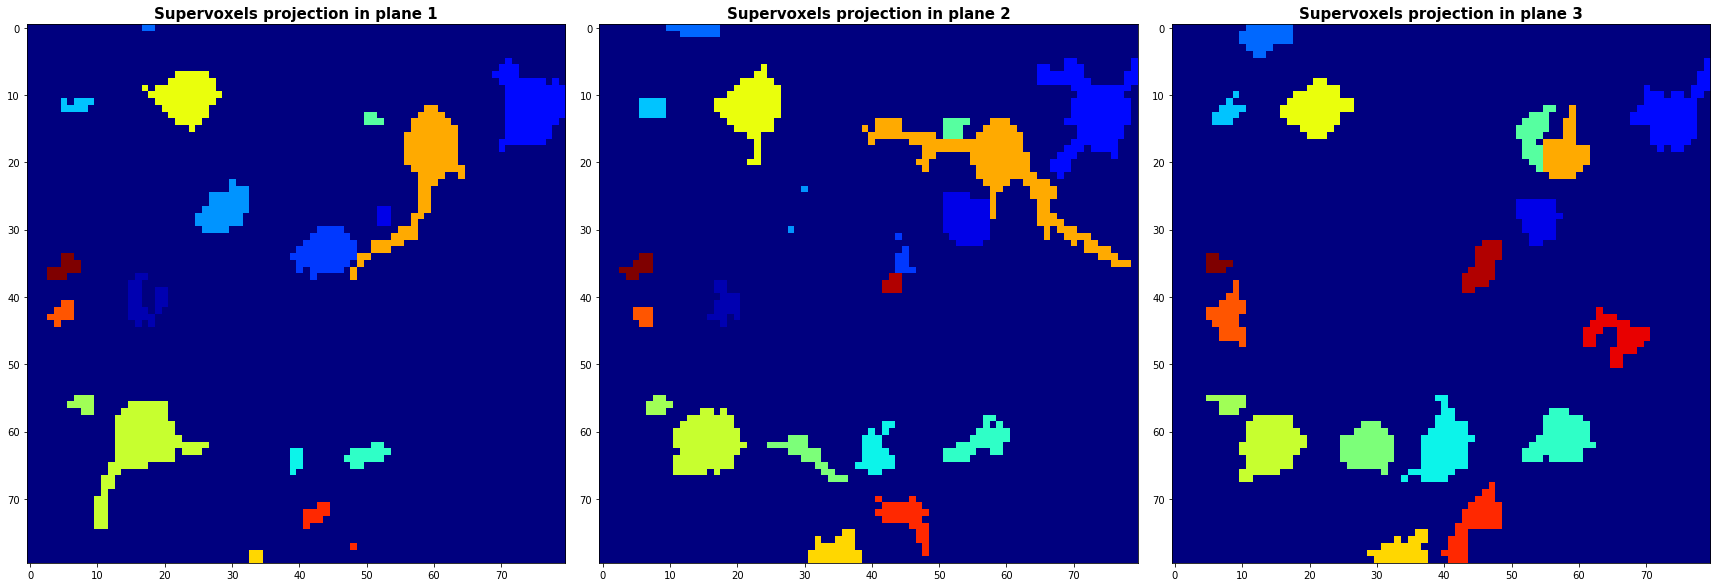

In [23]:
fig = plt.figure(figsize=(24,8))
for ii in range(3):
    plt.subplot(1,3,ii+1);
    plt.imshow(connect_mat_1[:,:,ii],cmap='jet');
    plt.title("Supervoxels projection in plane " + str(ii+1),fontsize=15,fontweight="bold");
fig.tight_layout()
#fig.savefig(out_dir + "superpixels in three planes.pdf")

In [24]:
Cnt = sup.local_correlations_fft(Yt);

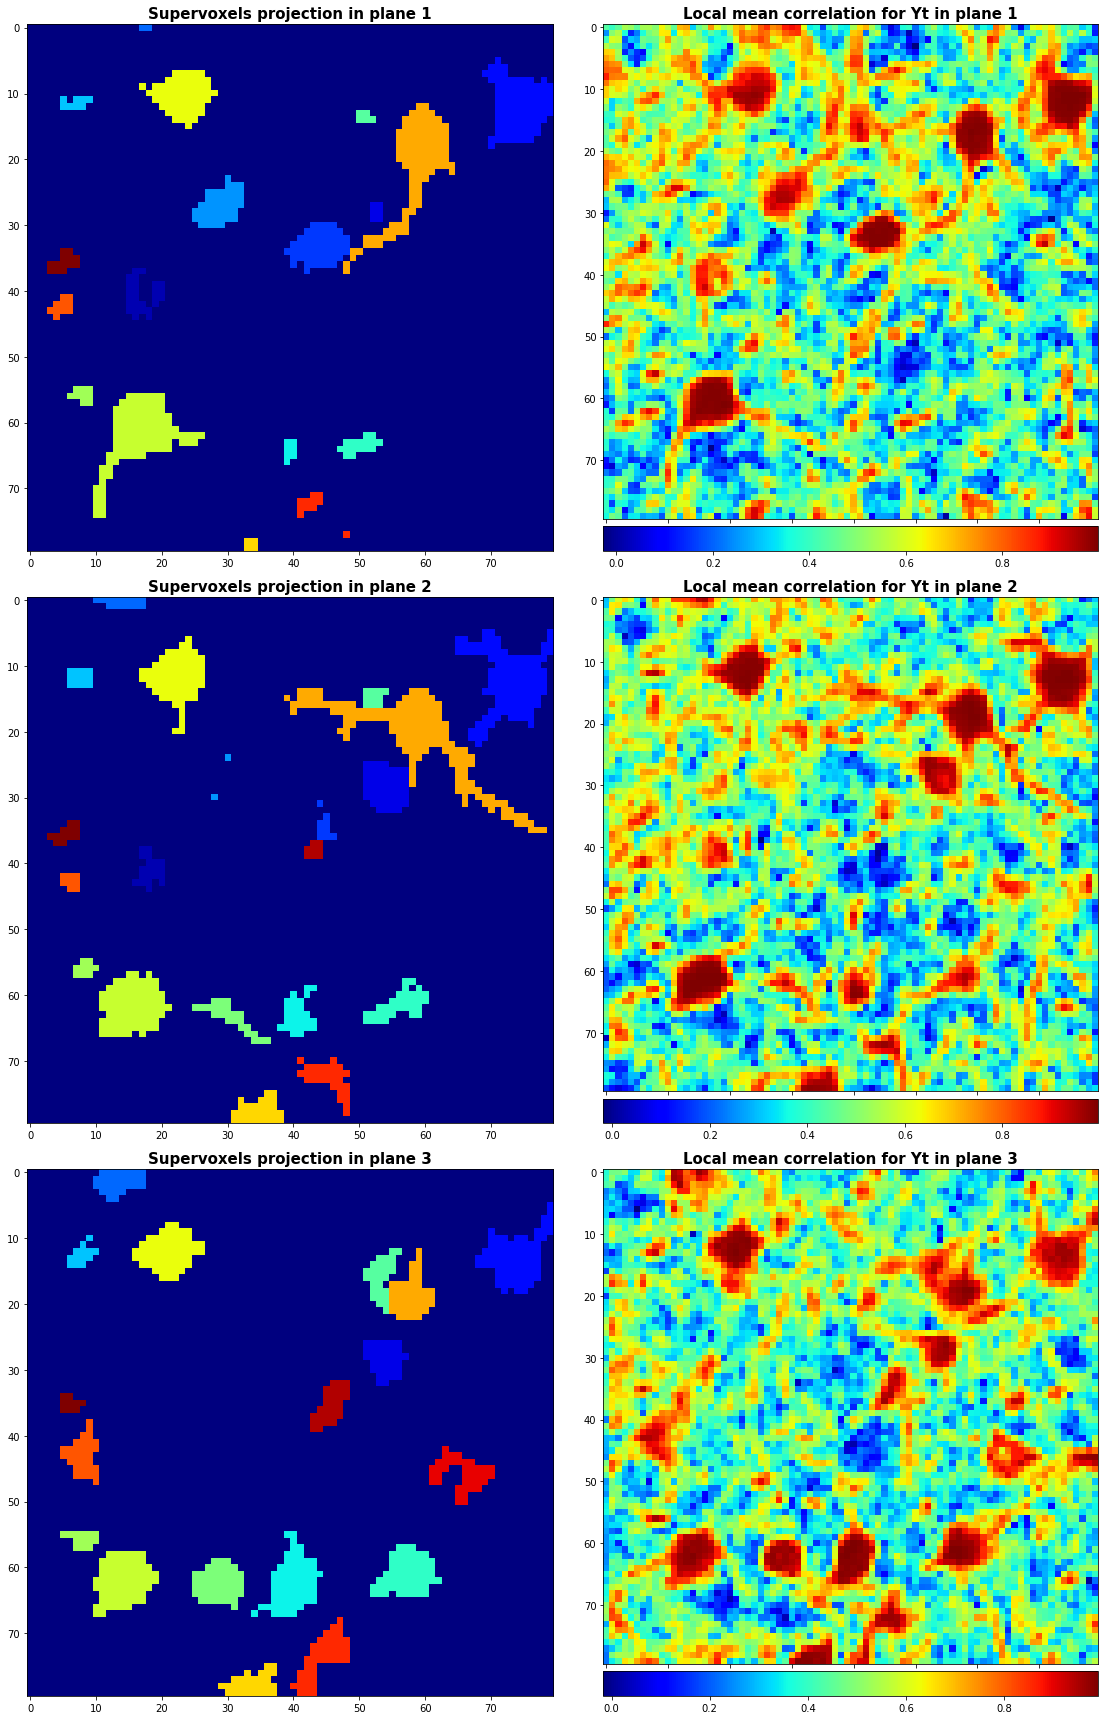

In [25]:
fig = plt.figure(figsize=(16,8*num_plane))
for ii in range(num_plane):
    ax = plt.subplot(num_plane,2,2*ii+1);
    ax.imshow(connect_mat_1[:,:,ii],cmap="jet");
    ax.set(title="Supervoxels projection in plane " + str(ii+1))
    ax.title.set_fontsize(15)
    ax.title.set_fontweight("bold")
    
    ax1 = plt.subplot(num_plane,2,2*ii+2);
    sup.show_img(ax1, Cnt.reshape(connect_mat_1.shape,order="F")[:,:,ii]);
    ax1.set(title="Local mean correlation for Yt in plane " + str(ii+1))
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold")
plt.tight_layout()

# rank-1 svd - find temporal trace for superpixels

In [26]:
V_mat, U_mat, B_mat = sup.spatial_temporal_ini(Yt, comps, idx, length_cut, maxiter=5, whole_data=True);

In [27]:
Ys_r = np.matmul(U_mat, V_mat.T) + B_mat.sum(axis=1).reshape(np.prod(dims[:2]),1)
Ys = Ys_r.reshape(dims[0],dims[1],T,order="F");

# SPA - find pure superpixel

In [28]:
################### specify a small region to find out all the pure superpixels in this region ##################
up=0;
down=79;
left=0;
right=79;

In [29]:
unique_pix, M = sup.search_superpixel_in_range([up,down],[left,right], connect_mat_1, permute_col, V_mat);

In [30]:
pure_pixels, coef, coef_rank = sup.fast_sep_nmf(M, M.shape[1], 0.6);

## Check each superpixel is composed by which pure superpixels

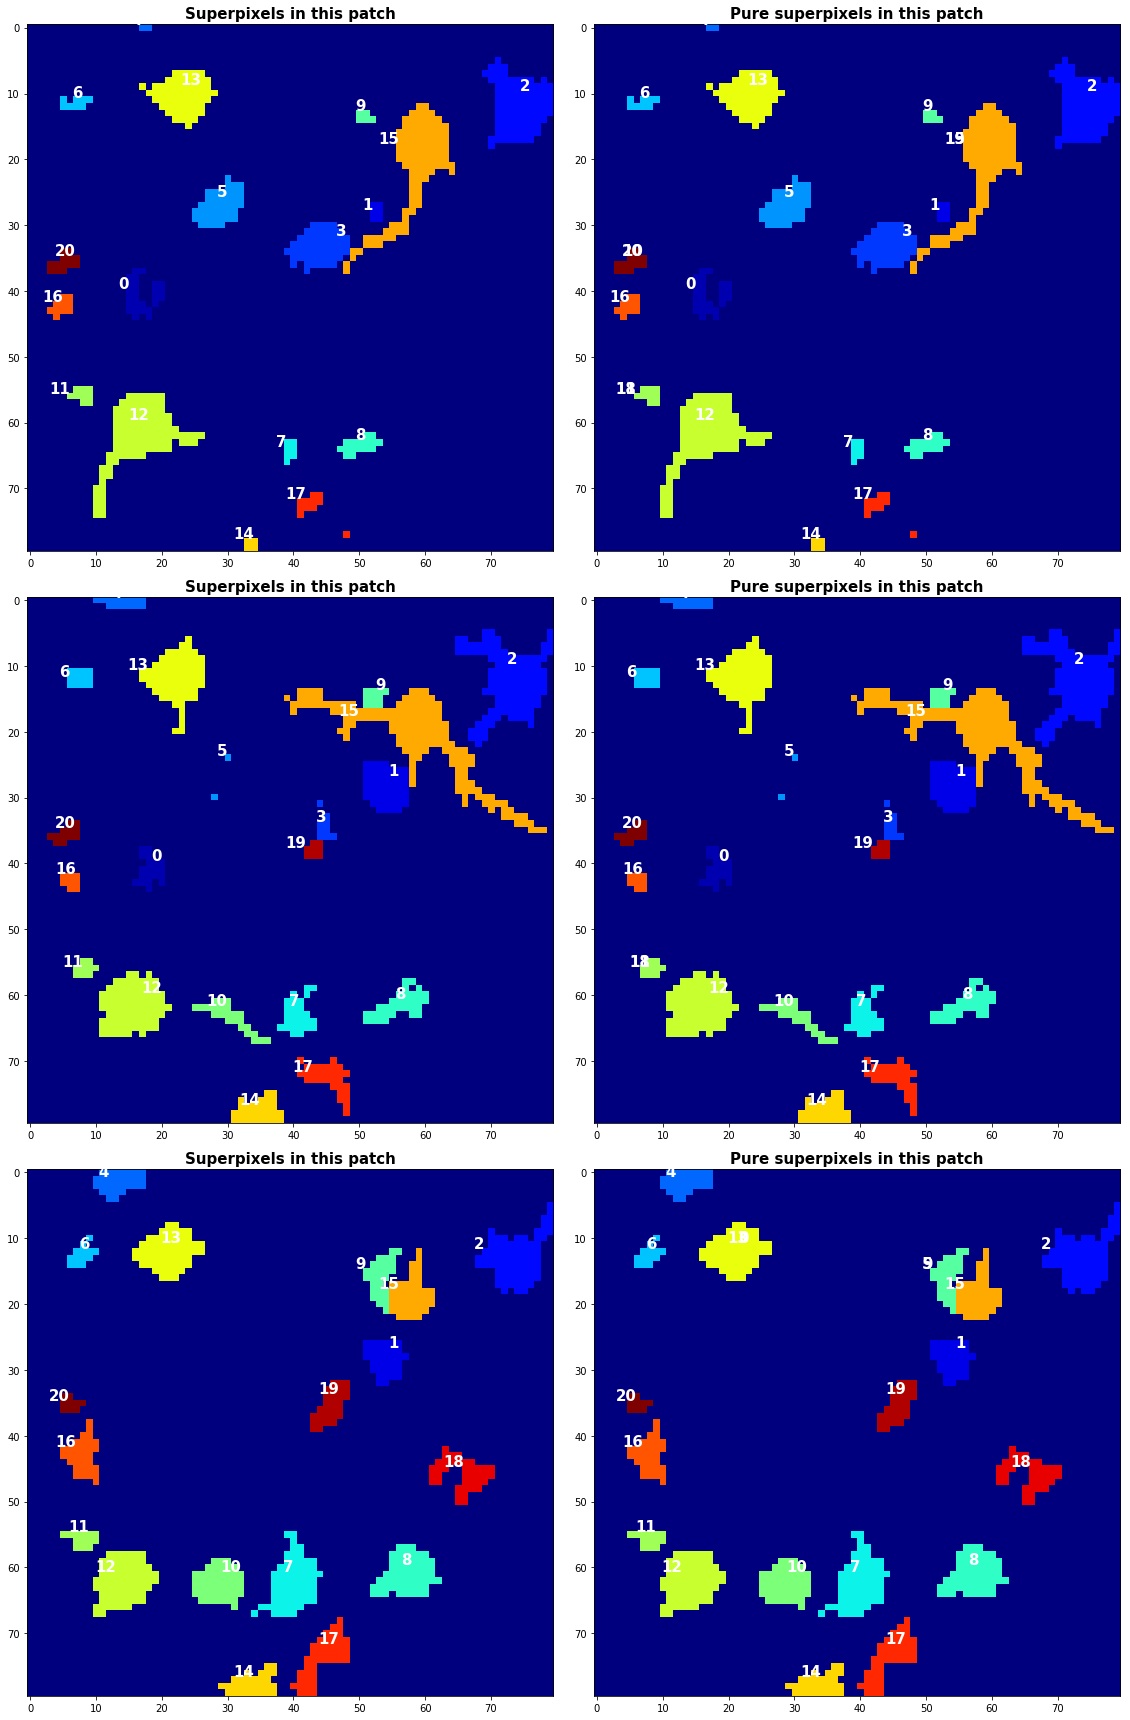

In [43]:
fig = plt.figure(figsize=(8*2,8*num_plane))

for jj in range(num_plane):
    ax = plt.subplot(num_plane,2,2*jj+1);
    ax.imshow(connect_mat_1[up:(down+1),left:(right+1),jj],cmap="jet");

    for ii in range(len(unique_pix)):
        pos = np.where(connect_mat_1[:,:,jj] == unique_pix[ii]);
        if pos[0].size:
            pos0 = pos[0] - up;
            pos1 = pos[1] - left;
            ax.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)], f"{ii}",
                verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
    ax.set(title="Superpixels in this patch")
    ax.title.set_fontsize(15)
    ax.title.set_fontweight("bold")

    ax1 = plt.subplot(num_plane,2,2*jj+2);
    ax1.imshow(connect_mat_1[up:(down+1),left:(right+1),jj],cmap="jet");

    for ii in range(len(pure_pixels)):
        pos = np.where(connect_mat_1[:,:,jj] == unique_pix[pure_pixels[ii]]);
        if pos[0].size:
            pos0 = pos[0] - up;
            pos1 = pos[1] - left;
        ax1.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)], f"{pure_pixels[ii]}",
            verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
    ax1.set(title="Pure superpixels in this patch")
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold")
plt.tight_layout()

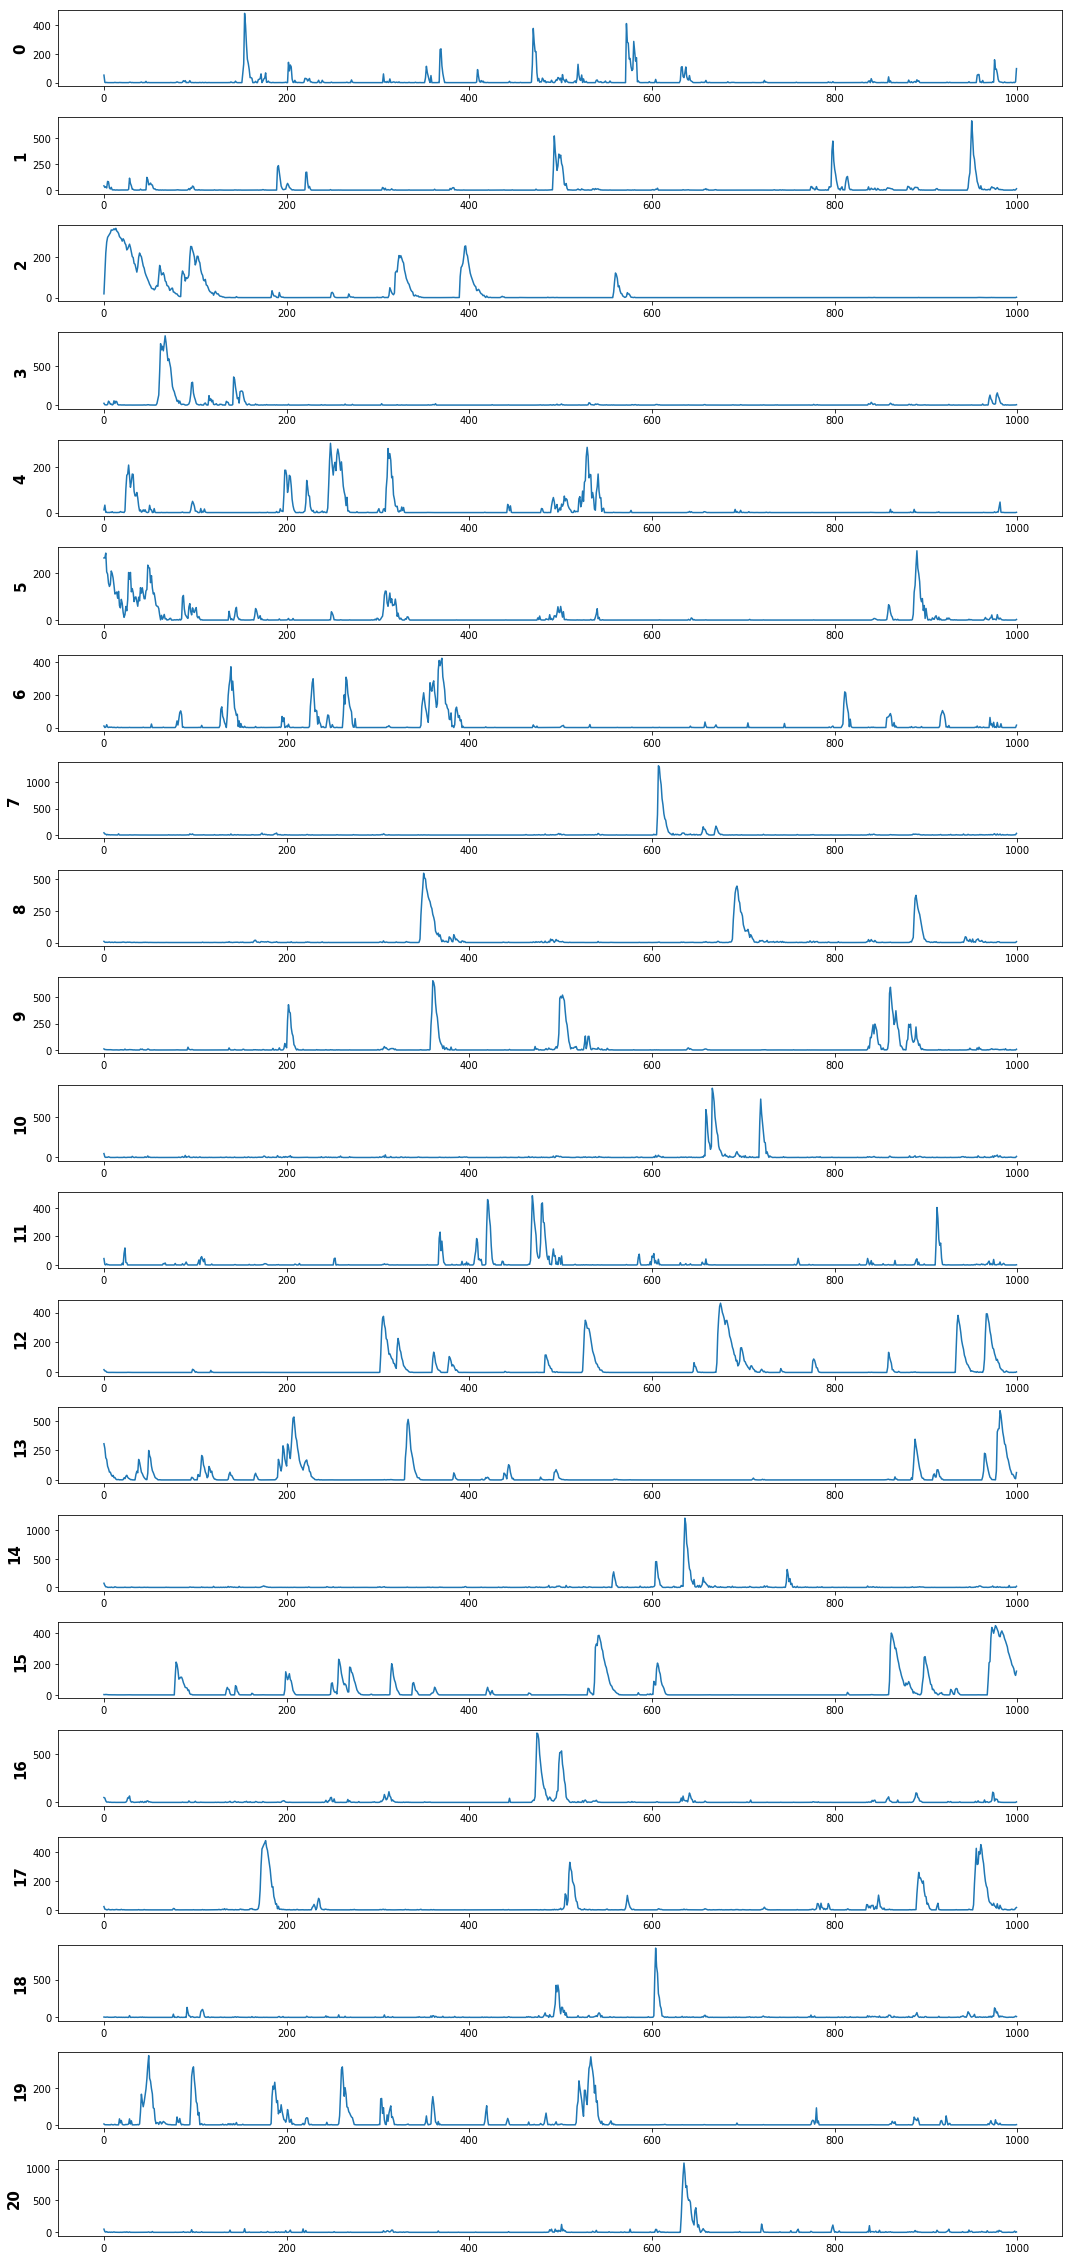

In [44]:
fig = plt.figure(figsize=(15,1.5*len(unique_pix)));
for ii in range(len(unique_pix)):
    plt.subplot(len(unique_pix),1,ii+1);
    plt.ylabel(str(ii),fontweight="bold",fontsize=15)
    pos = np.where(permute_col == unique_pix[ii])[0][0];
    plt.plot(V_mat[:,pos]);
plt.tight_layout()

In [45]:
coef_rank[:,9]

array([ 9., 16.,  4., 11., 12.,  8., 18., 13., 17.,  3., 20.,  0., 10.,
        7., 19., 14.,  2., 15.,  6.,  1.,  5.])

# visualize pure superpixels

In [46]:
a_ini, c_ini, y0, brightness_rank, pure_pix, corr_img_all_r = sup.prepare_iteration(Yt, connect_mat_1, permute_col, unique_pix, pure_pixels, V_mat, U_mat, [up,down],[left,right],num_plane=3)

3D data!


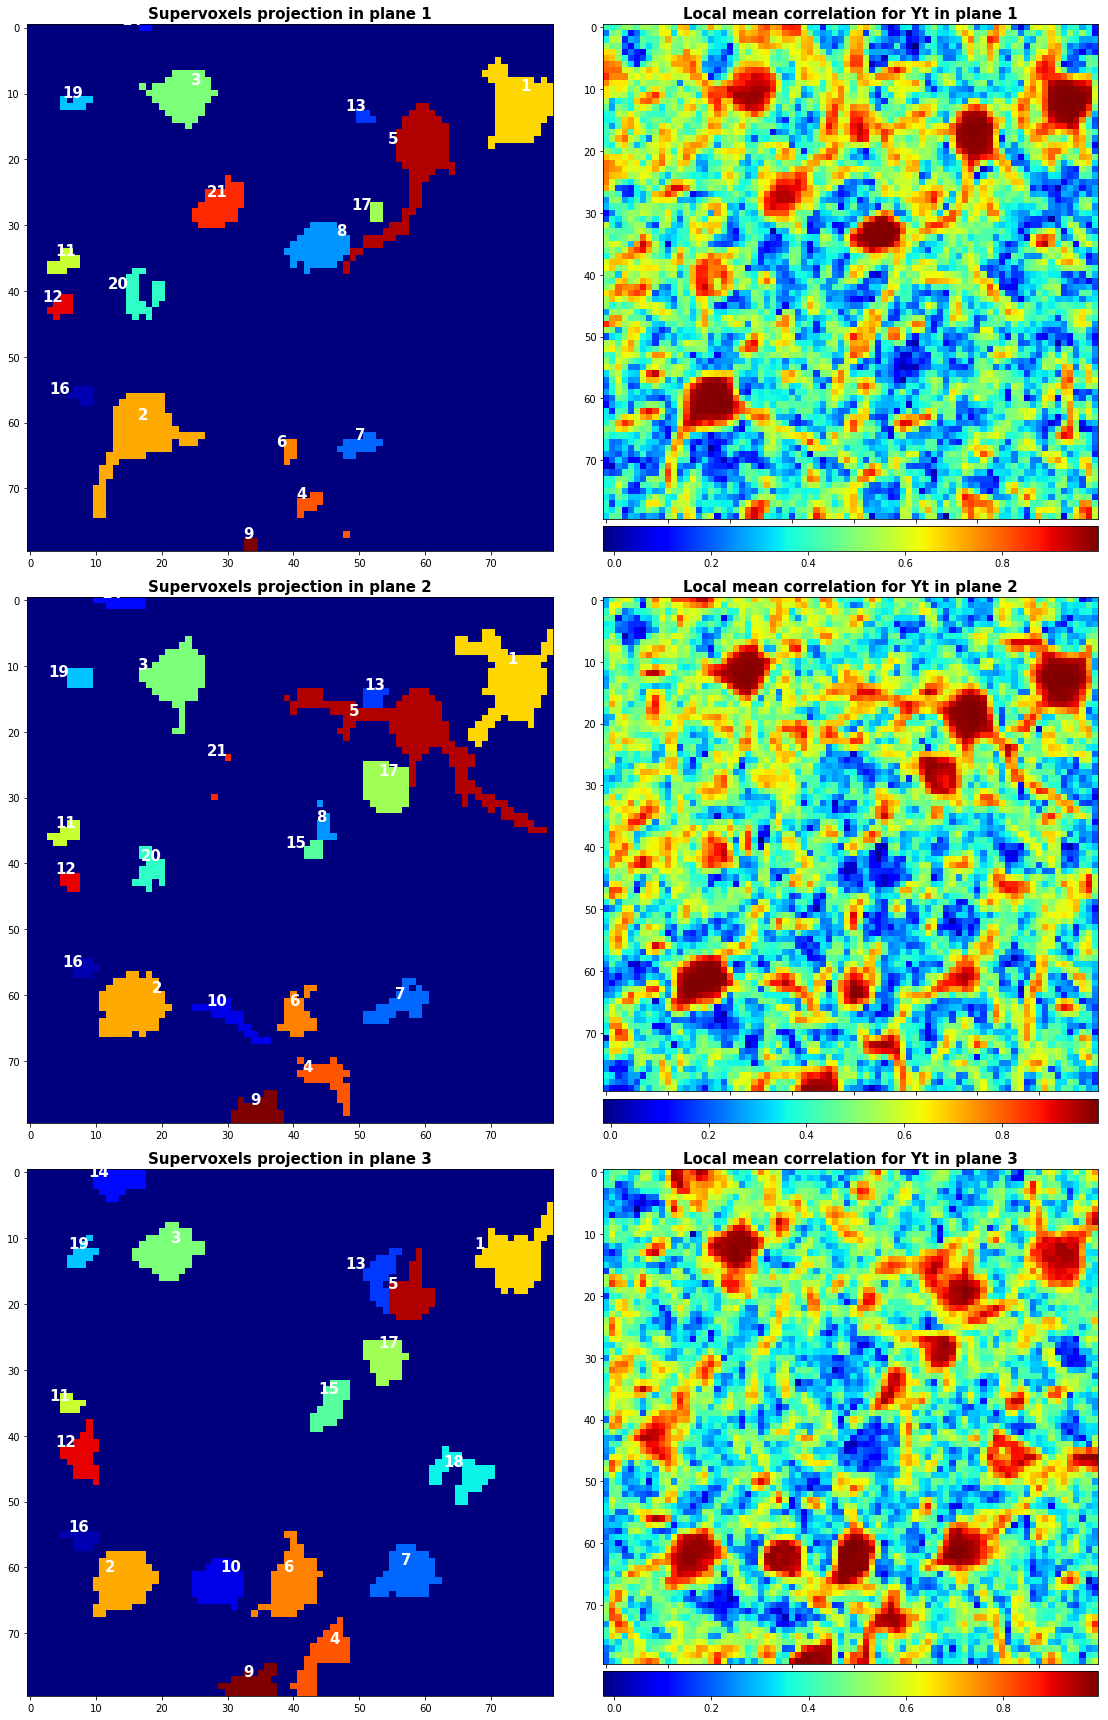

In [60]:
fig = plt.figure(figsize=(16,8*num_plane))
for ii in range(num_plane):
    ax = plt.subplot(num_plane,2,2*ii+1);
    ax.imshow(connect_mat_1[:,:,ii],cmap='jet');
    for jj in range(len(pure_pix)):
        pos = np.where(connect_mat_1[:,:,ii] == pure_pix[jj]);
        if pos[0].size:
            pos0 = pos[0] - up;
            pos1 = pos[1] - left;
            ax.text((pos1)[np.array(len(pos1)/3,dtype=int)], (pos0)[np.array(len(pos0)/3,dtype=int)], f"{brightness_rank[jj]}",
                verticalalignment='bottom', horizontalalignment='right',color='white', fontsize=15, fontweight="bold")
    plt.title("Supervoxels projection in plane " + str(ii+1),fontsize=15,fontweight="bold");
    ax1 = plt.subplot(num_plane,2,2*ii+2);
    sup.show_img(ax1, Cnt.reshape(connect_mat_1.shape,order="F")[:,:,ii]);
    ax1.set(title="Local mean correlation for Yt in plane " + str(ii+1));
    ax1.title.set_fontsize(15)
    ax1.title.set_fontweight("bold")
fig.tight_layout()
#fig.savefig("corr_labeled_fig.pdf")

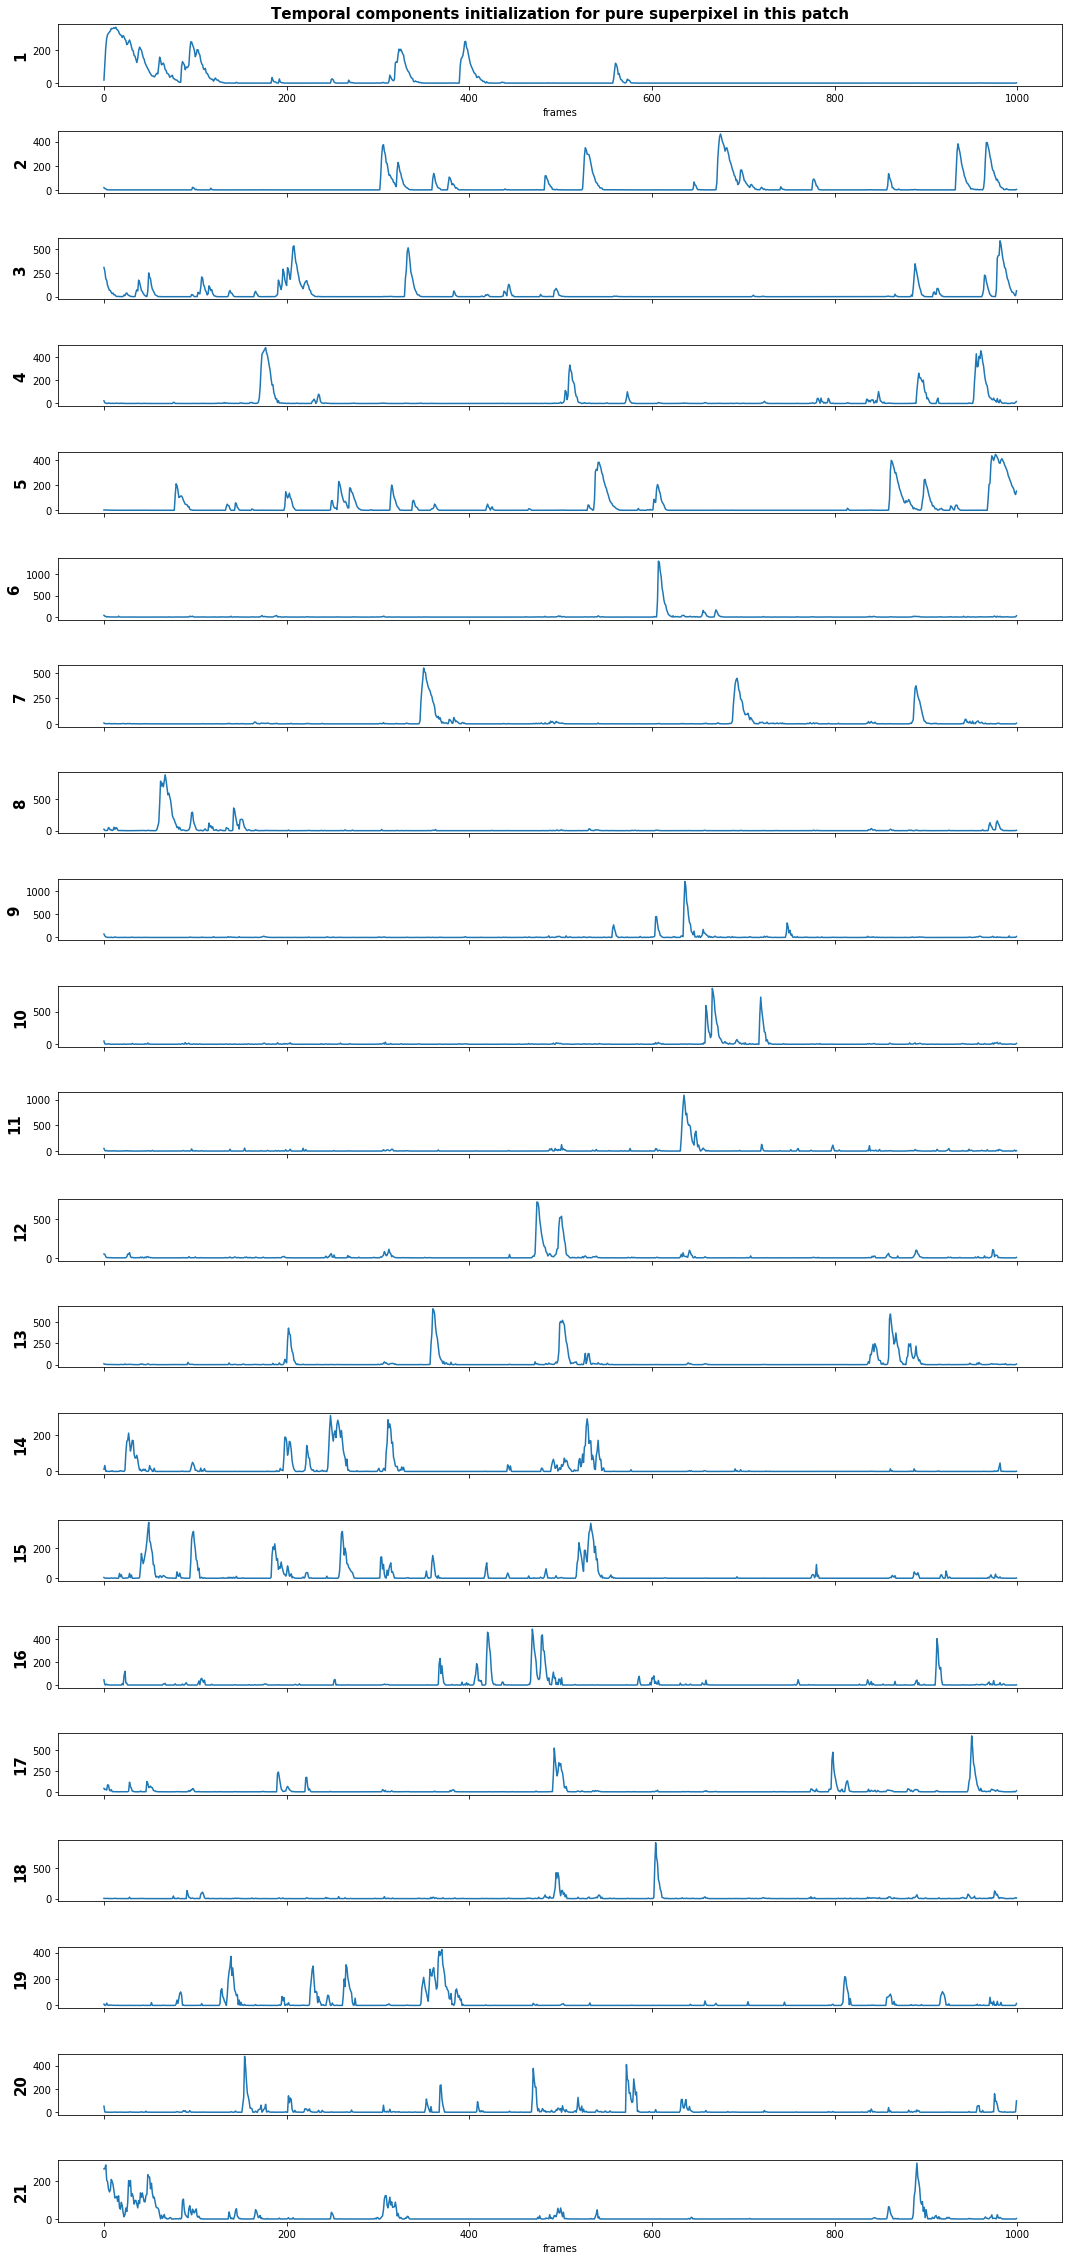

In [61]:
num = len(pure_pix);
fig = plt.figure(figsize=(15,1.5*num))
#fig = plt.figure(figsize=(15,1.5*8))
for ii in range(num):
    plt.subplot(num,1, ii+1);
    plt.plot(c_ini[:,ii]);
    if ii == 0:
        plt.title("Temporal components initialization for pure superpixel in this patch",fontweight="bold",fontsize=15);
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout()


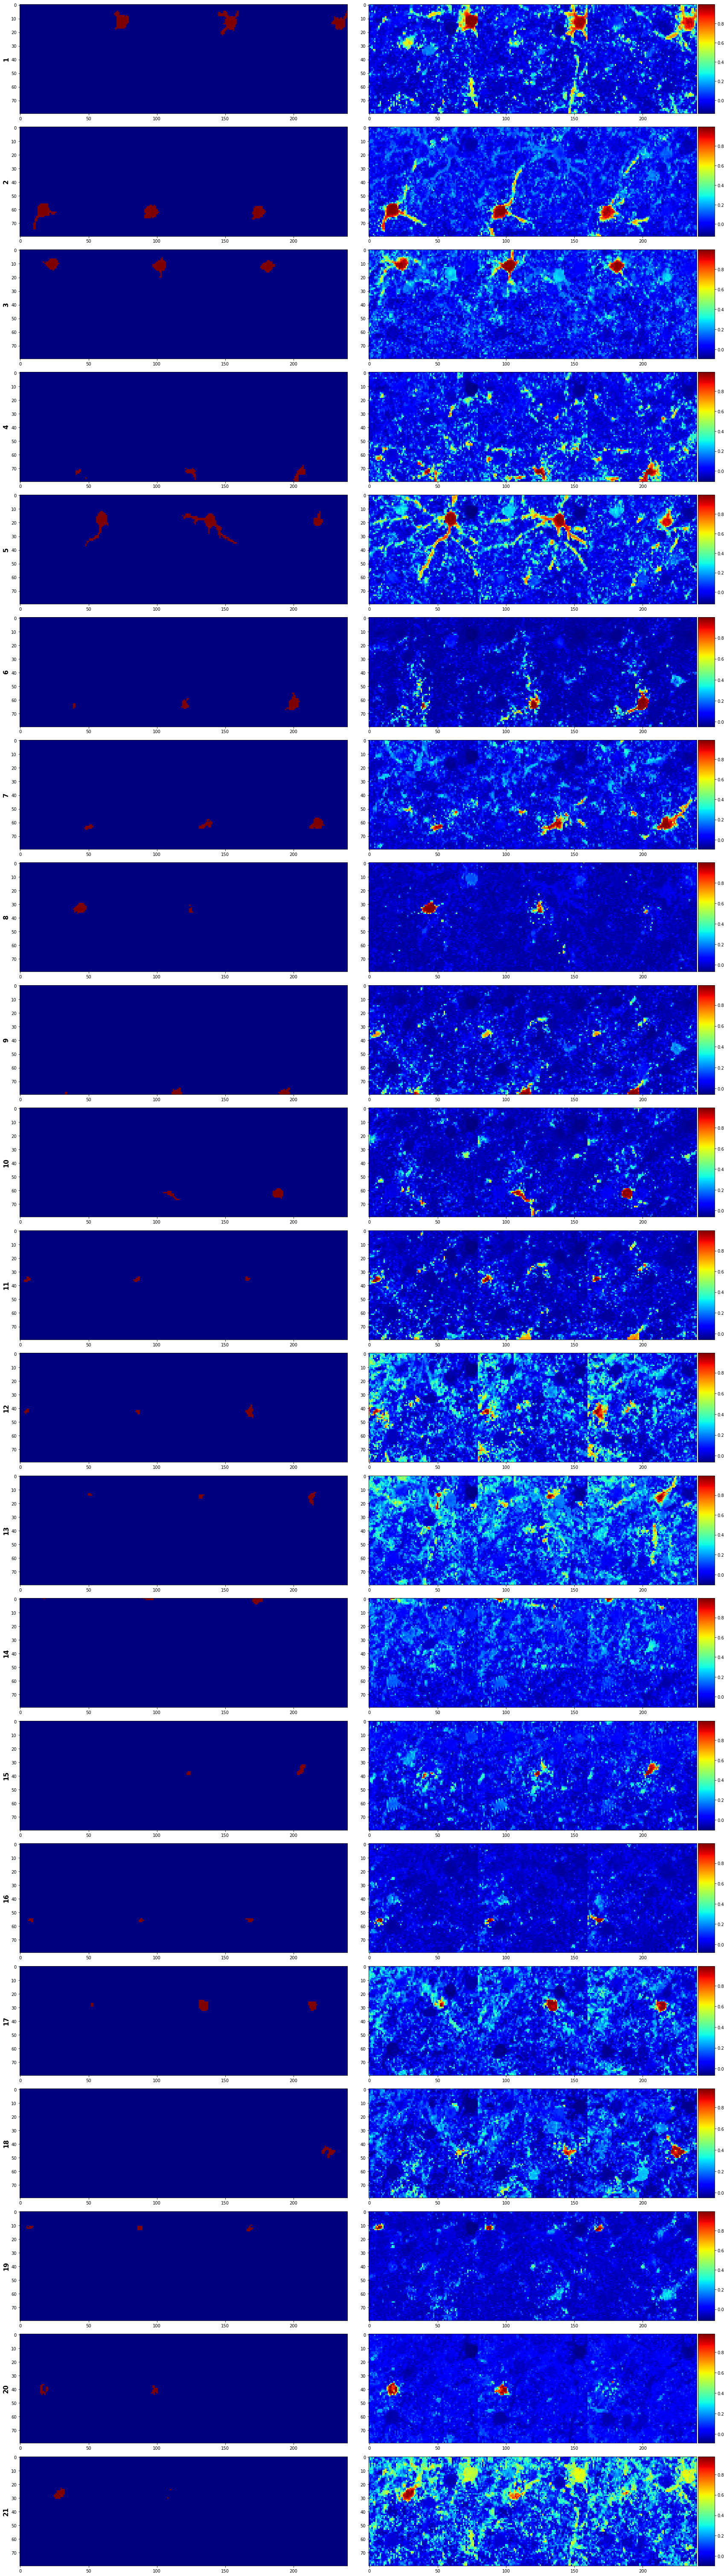

In [76]:
num = len(pure_pix);
fig = plt.figure(figsize=(num_plane*4*2,num*4));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(connect_mat_1[up:(down+1),left:(right+1)].reshape(dims[0],dims[1],order="F") == pure_pix[np.where(brightness_rank == ii+1)[0]],cmap="jet");
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15);
    #plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax=plt.subplot(num,2,2*(ii+1));
    fig2=ax.imshow(corr_img_all_r[:,:,ii],cmap="jet");
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(fig2,cax=cax, orientation='vertical')
fig.tight_layout();


# Iteratively update A and C

In [169]:
###################### test vanilla nmf #####################################
model = NMF(n_components=len(pure_pixels[0,:]), init='random', random_state=0)
W = model.fit_transform(y0)
H = model.components_

In [78]:
###################### test nmf with initialization ##########################
model = NMF(n_components=len(pure_pixels[0,:]), init='custom')
W1 = model.fit_transform(y0, W=a_ini.copy(), H = abs(c_ini.T));
H1 = model.components_

In [80]:
corr_th_ini = 0.8;
corr_th_dilate = [0.5];
corr_th_fix = 0.3;
maxiter=100;
tol=1e-8;
a, a_ini, c, c_ini, b, res = sup.update_AC_l2(y0, c_ini, corr_img_all_r, corr_th_ini, 
                                                    corr_th_fix, corr_th_dilate, dilate_times=2, 
                                                    maxiter=maxiter, tol=tol, whole_data=True);

correct number of correlation threshold!
1.84779400494e-09


In [81]:
corr_th_ini = 0.8;
corr_th_dilate = [0.5];
corr_th_fix = 0.3;
maxiter=100;
tol=1e-8;
maxiter_nr=100;
tol_nr=1;
a3, a_ini3, c3, c_ini3, b3, res3 = sup.update_AC_huber(y0, c_ini, corr_img_all_r, 
                                                   corr_th_ini, corr_th_fix,
                                                   corr_th_dilate, dilate_times=2, 
                                                   maxiter=maxiter, tol=tol, maxiter_nr=maxiter_nr, tol_nr=tol_nr);

correct number of correlation threshold!
1.31732635922e-05


# visualize NMF results

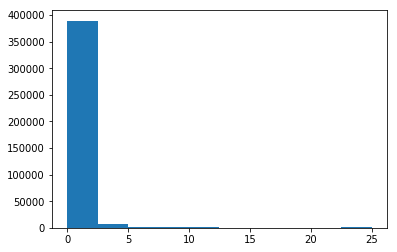

In [114]:
visual_a = W1.copy();
visual_a = (visual_a - visual_a.min())/(visual_a.max() - visual_a.min())*255
plt.hist(np.clip(visual_a,0,25).ravel())
visual_a = np.clip(visual_a,0,25)

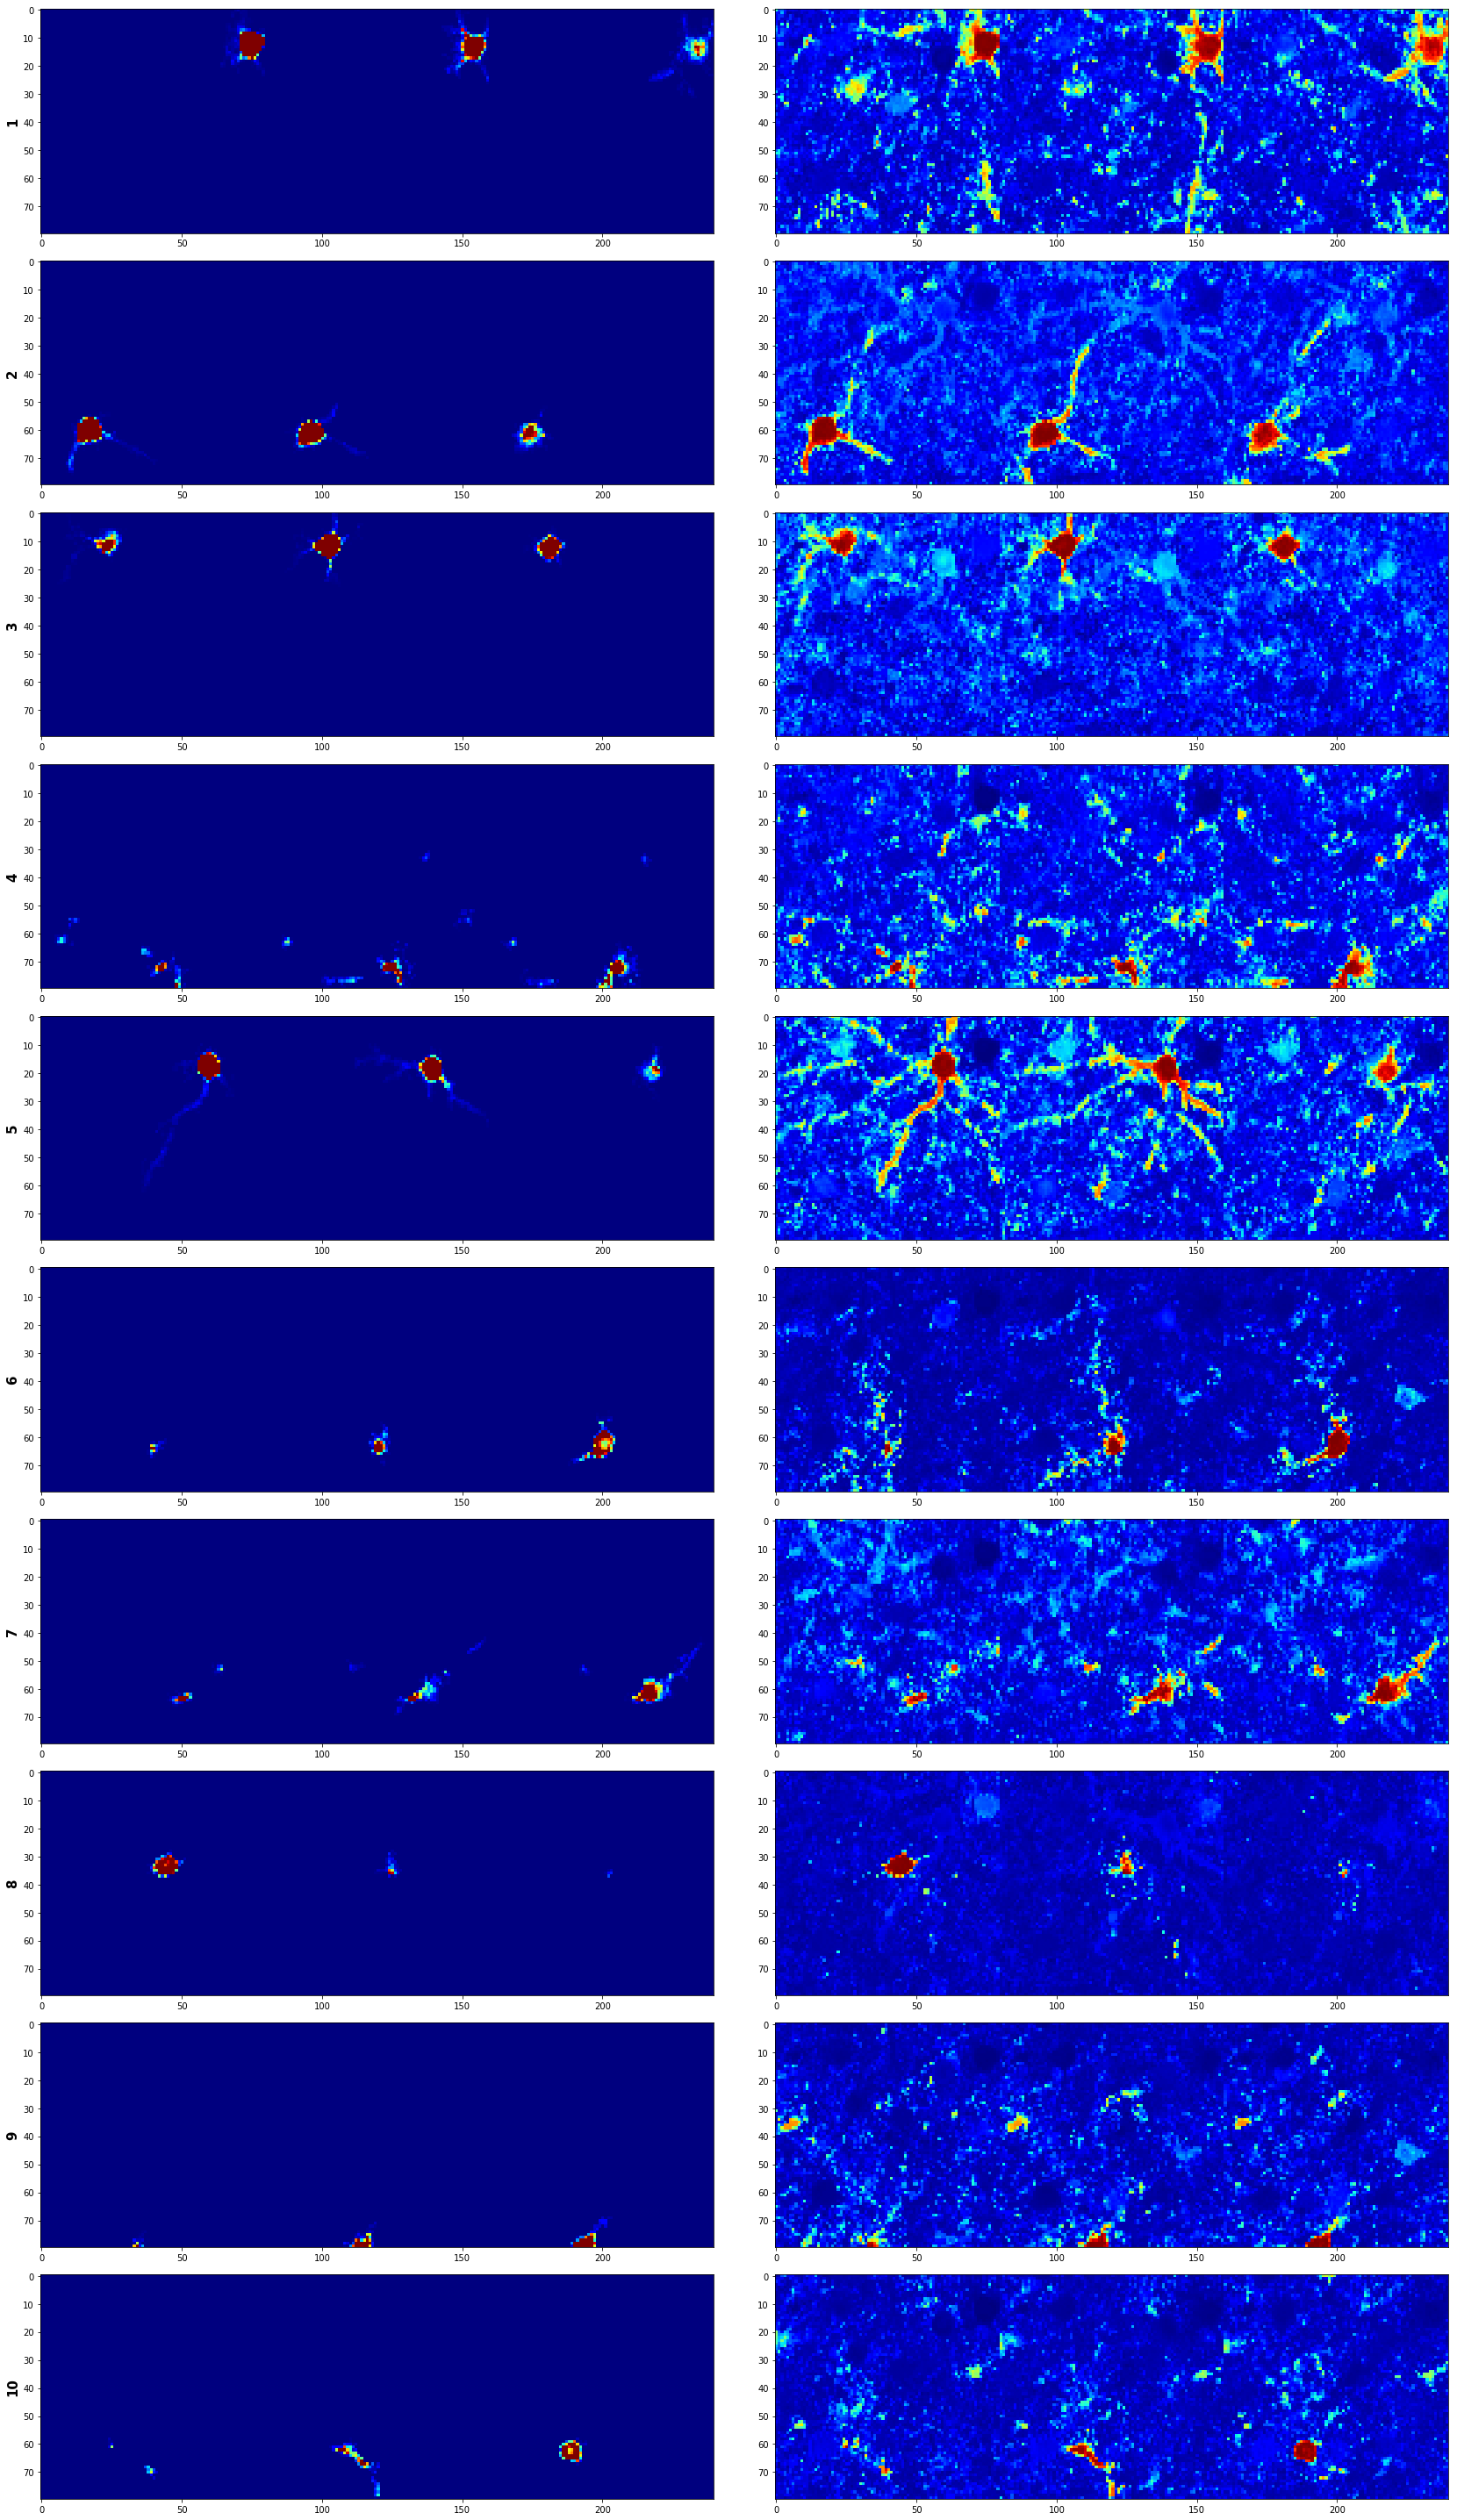

In [112]:
num=10#len(pure_pix);
fig = plt.figure(figsize=(4*2*num_plane,4*num));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(visual_a[:,ii].reshape((down-up+1),num_plane*(right-left+1),order="F"),cmap='jet');
    plt.ylabel(str(ii+1),fontsize=15,fontweight="bold");
    plt.subplot(num,2,2*(ii+1));
    plt.imshow(corr_img_all_r[:,:,ii],cmap='jet');  
fig.tight_layout()
fig.savefig(out_dir + "spatial_huber_constrain_subset.pdf")

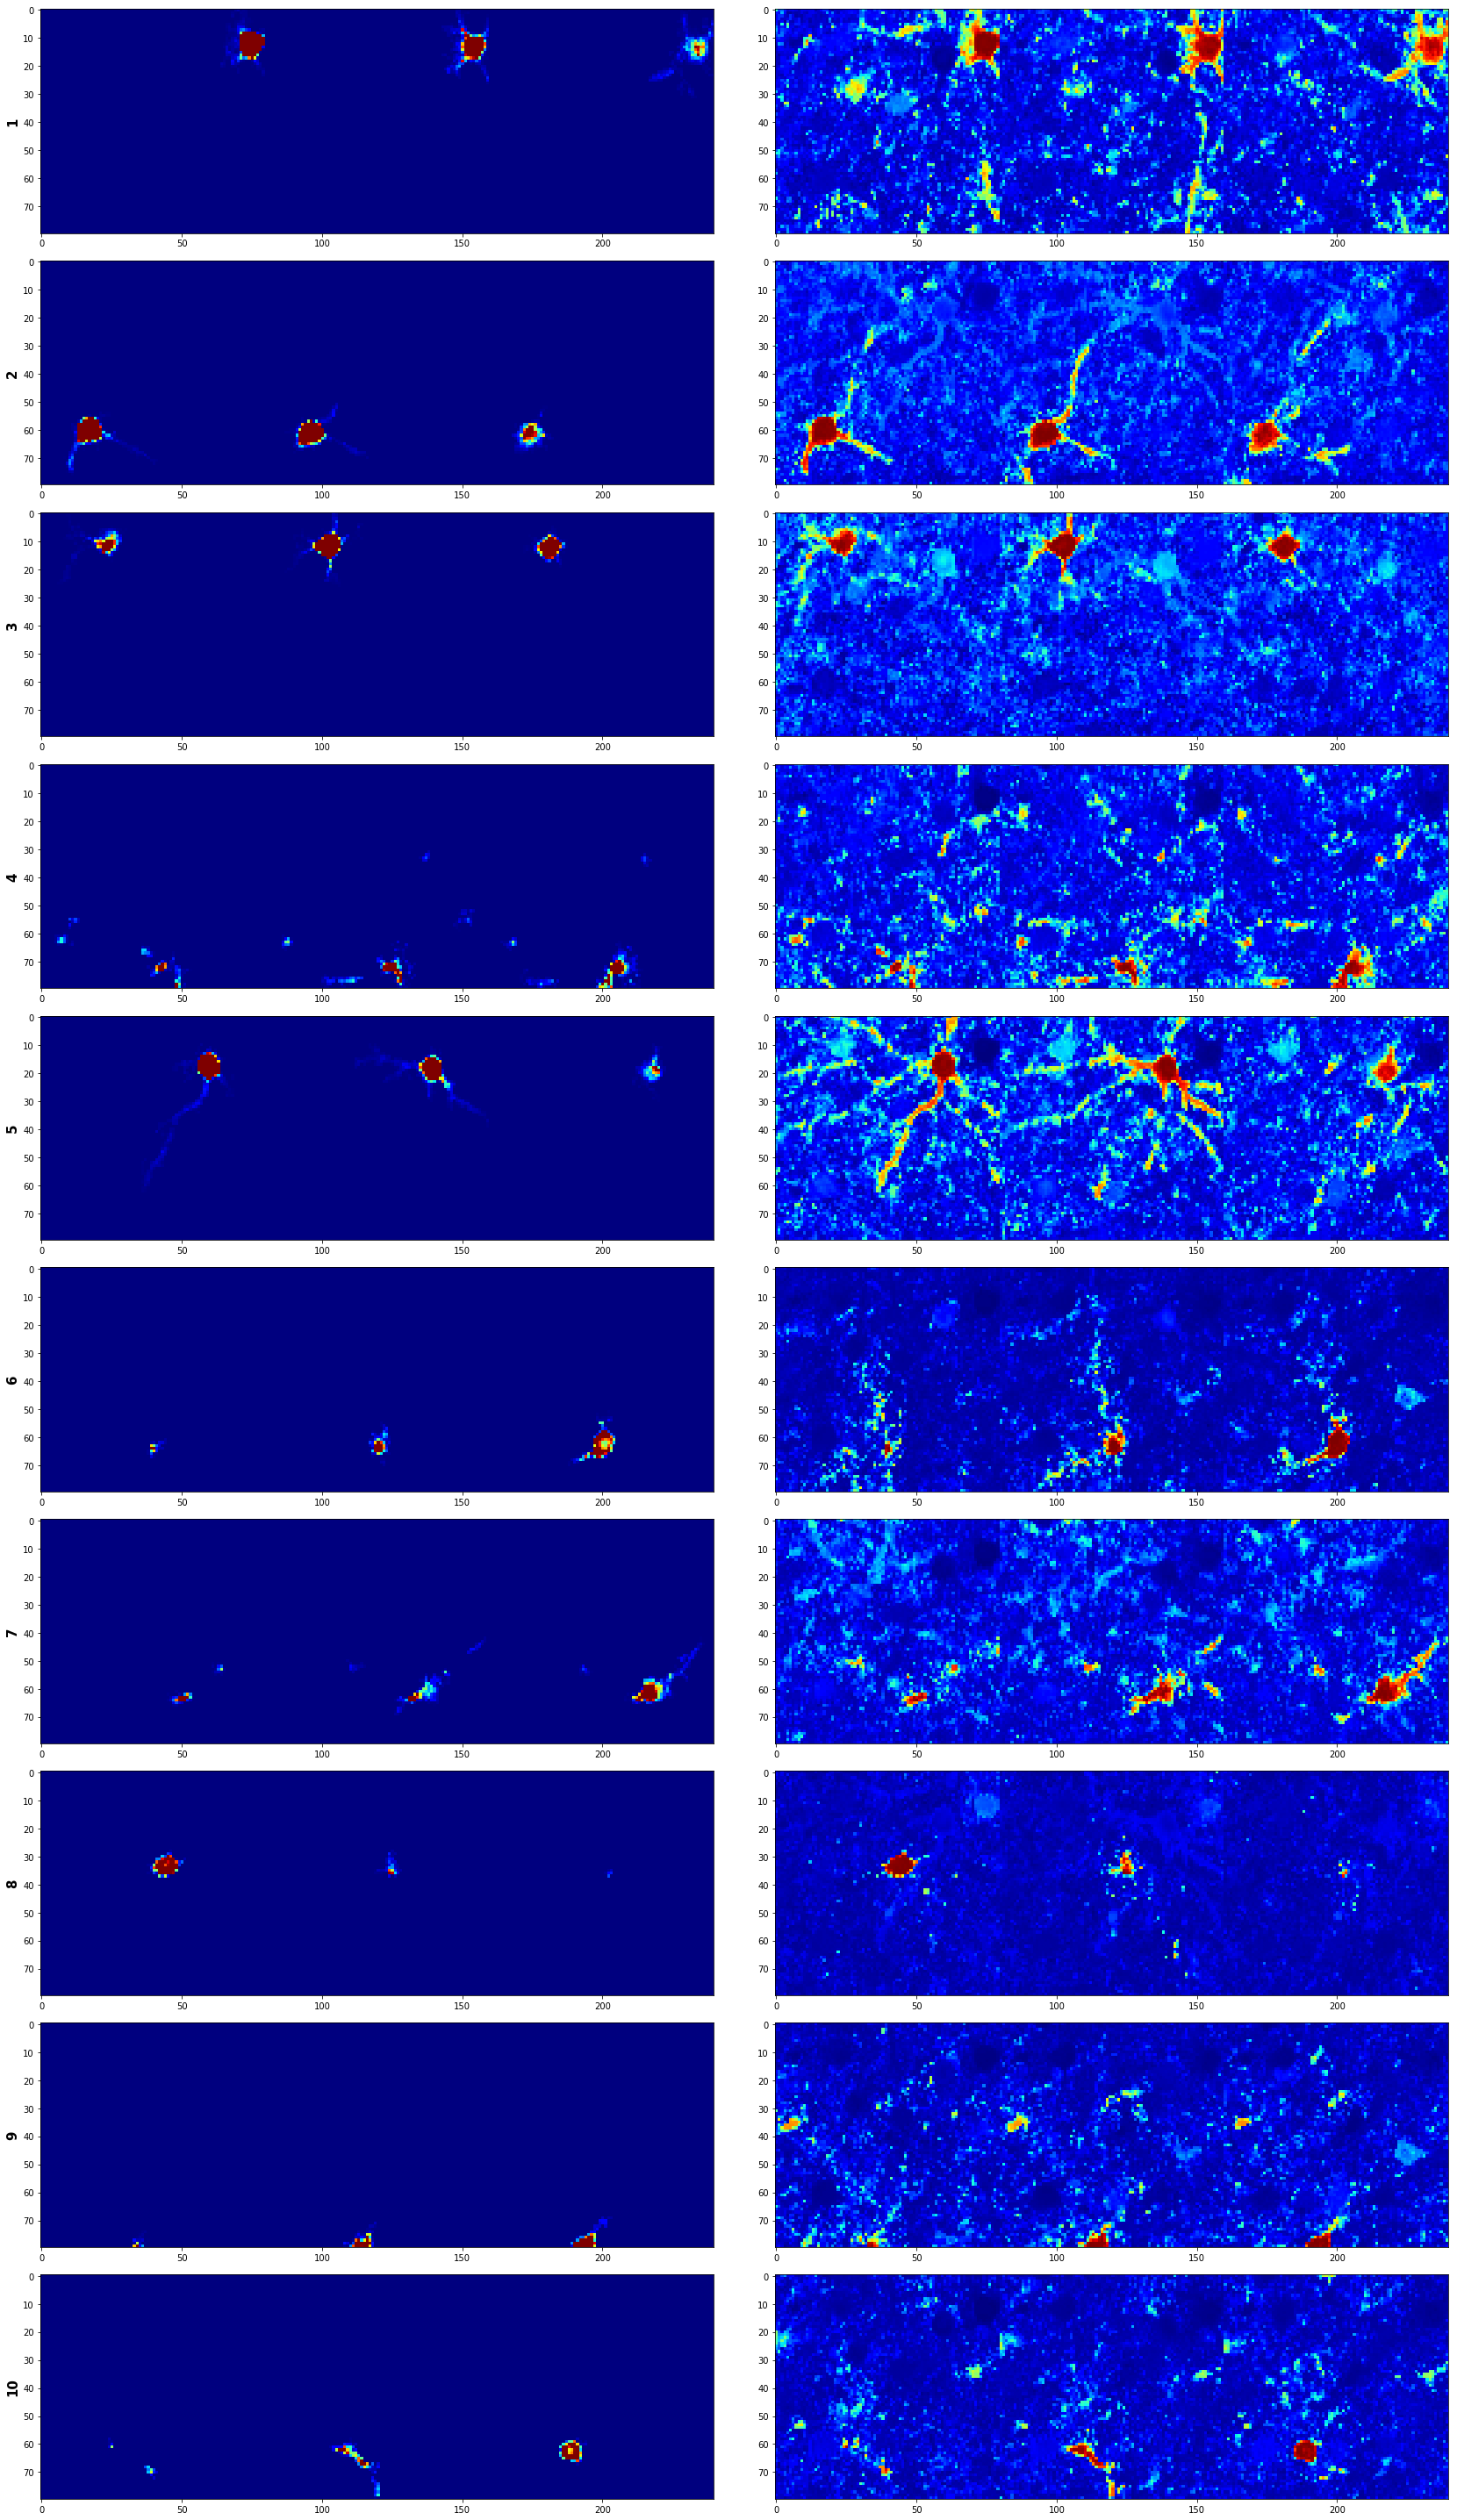

In [113]:
num=10;#len(pure_pix);
fig = plt.figure(figsize=(4*2*num_plane,4*num));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(visual_a[:,ii].reshape((down-up+1),num_plane*(right-left+1),order="F"),cmap='jet');
    plt.ylabel(str(ii+1),fontsize=15,fontweight="bold");
    plt.subplot(num,2,2*(ii+1));
    plt.imshow(corr_img_all_r[:,:,ii],cmap='jet');  
fig.tight_layout()
fig.savefig(out_dir + "spatial_nmf_constrain_subset.pdf")

In [99]:
corr_img_all = np.zeros([(down-up+1)*(right-left+1)*num_plane, len(pure_pix)]);
for ii in range(len(pure_pix)):
    corr_img_all[:,ii] = sup.vcorrcoef(y0, H1[ii,:]);
corr_img_all_rw1 = corr_img_all.reshape((down-up+1),(right-left+1)*num_plane,len(pure_pix),order="F");

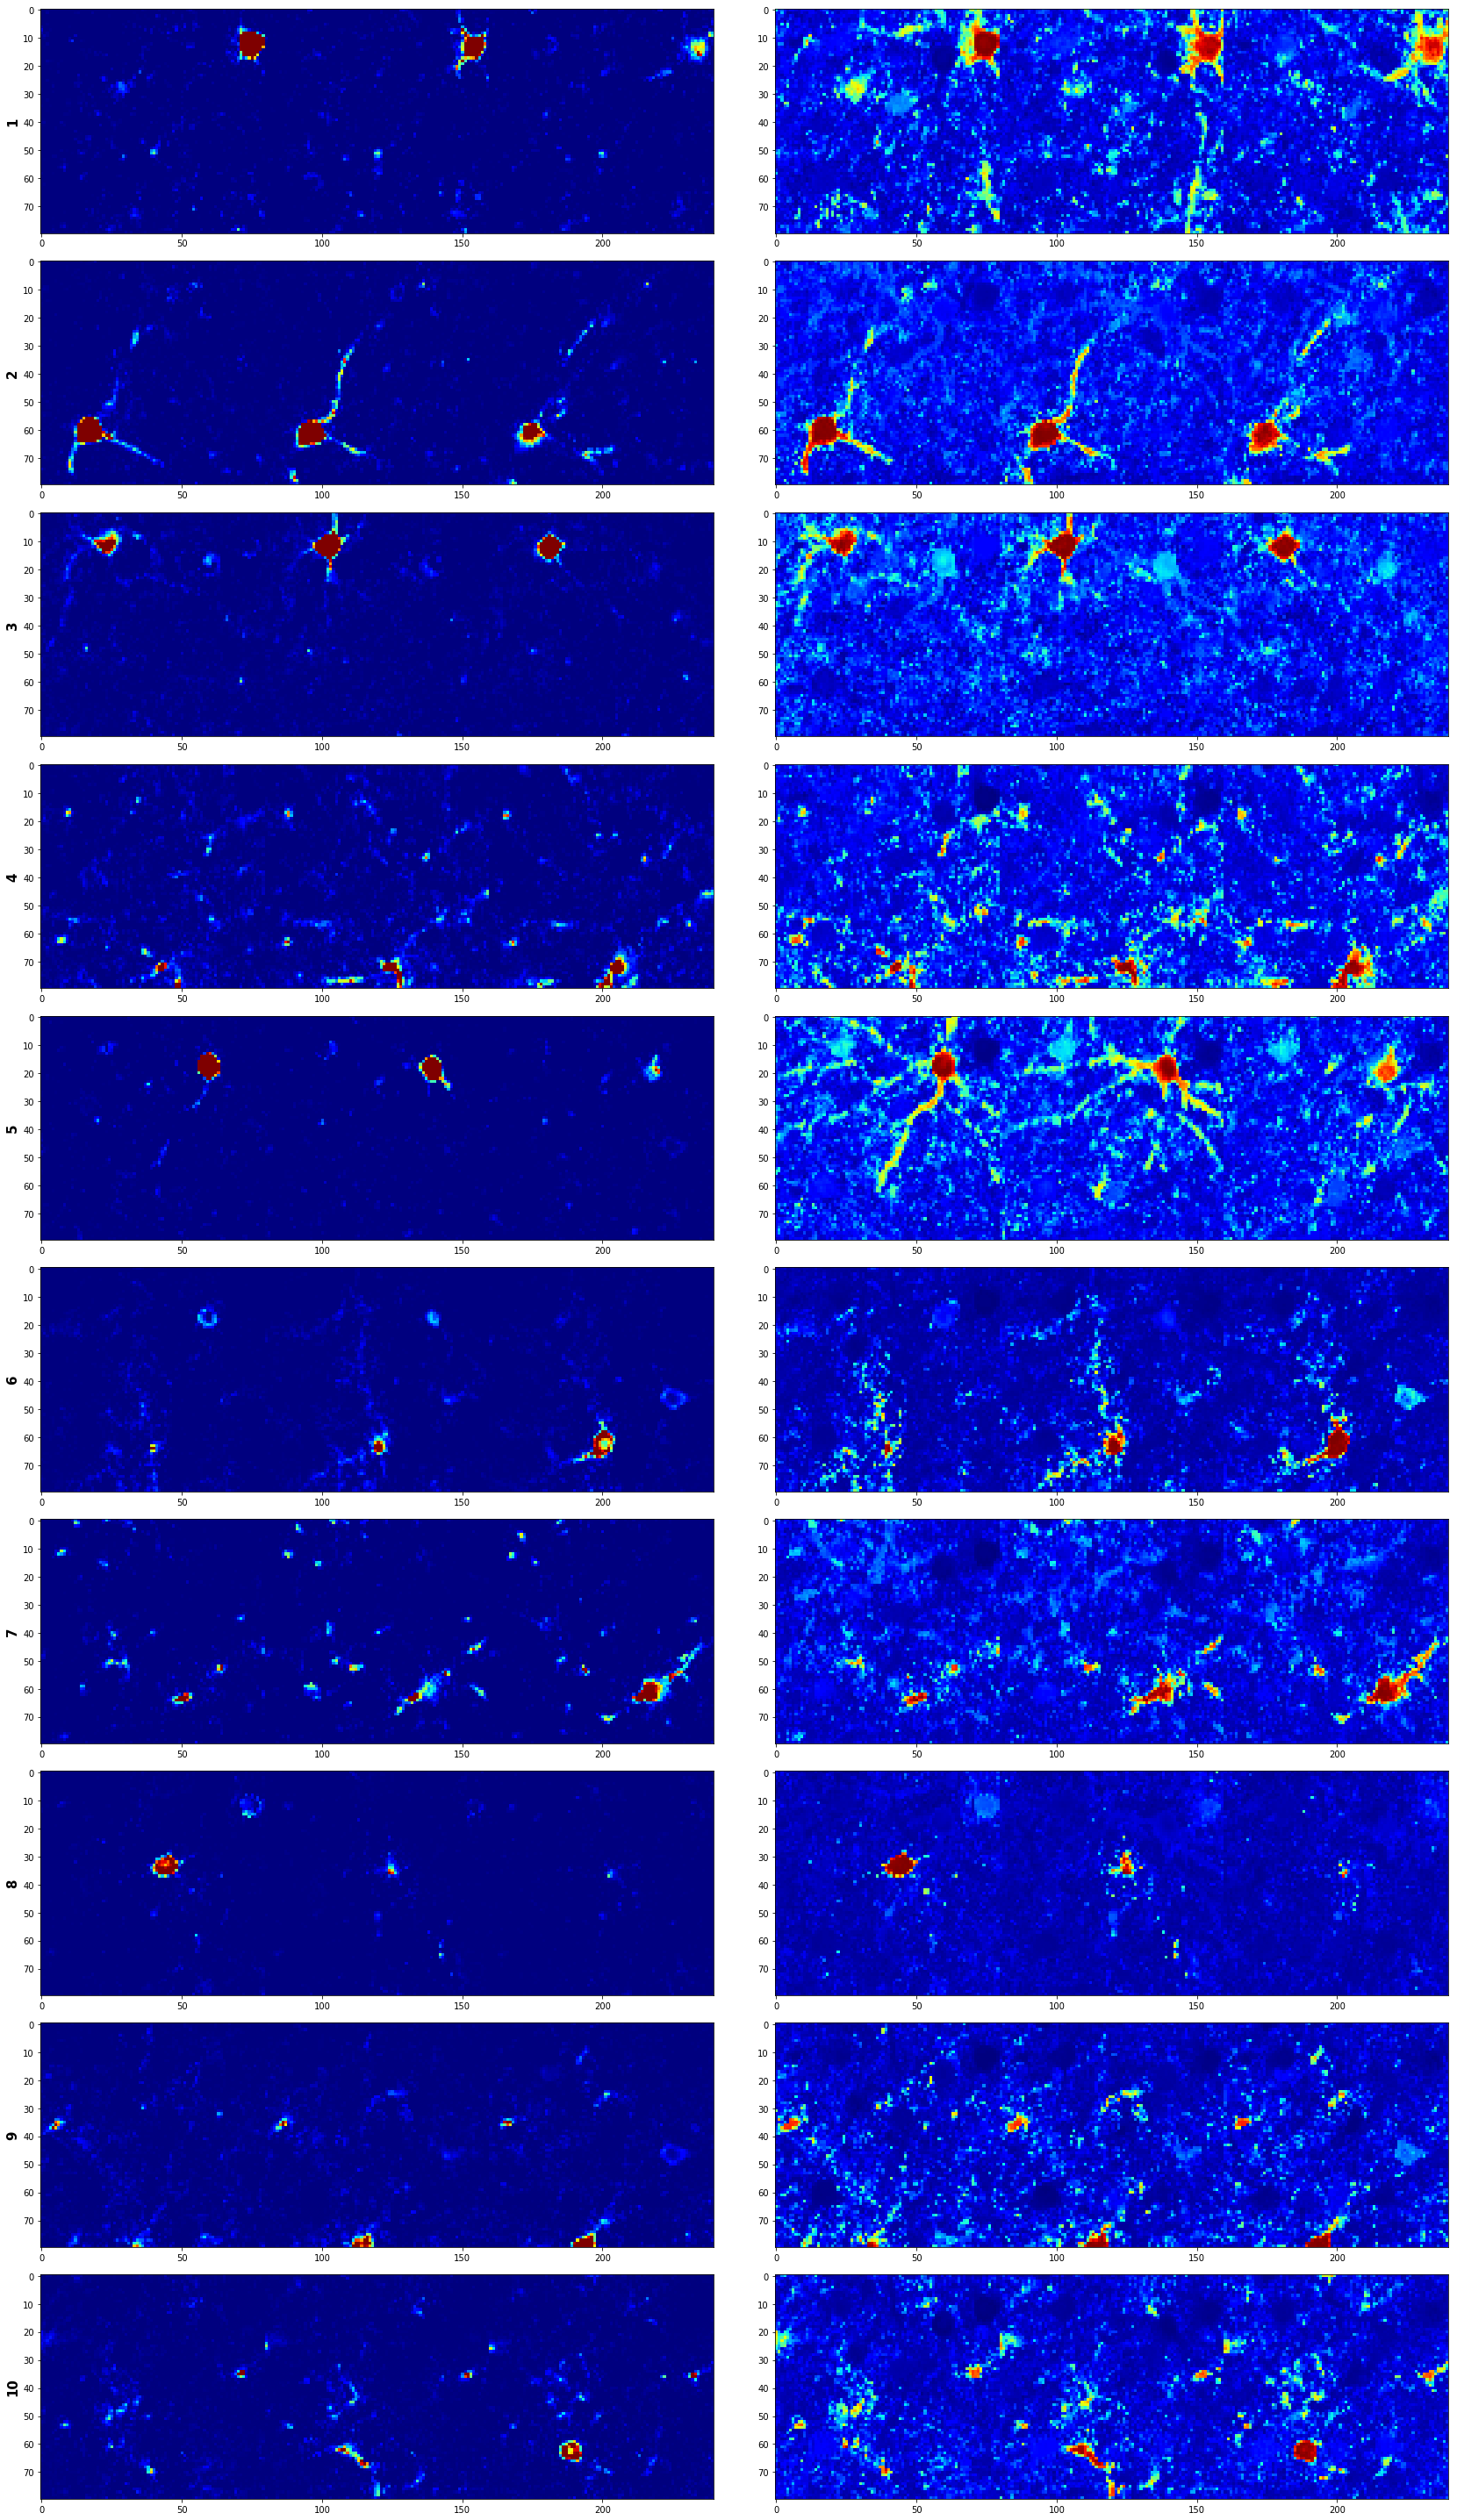

In [115]:
num=10;#len(pure_pix);
fig = plt.figure(figsize=(4*2*num_plane,4*num));
for ii in range(num):
    plt.subplot(num,2,2*ii+1);
    plt.imshow(visual_a[:,ii].reshape((down-up+1),num_plane*(right-left+1),order="F"),cmap='jet');
    plt.ylabel(str(ii+1),fontsize=15,fontweight="bold");
    plt.subplot(num,2,2*(ii+1));
    plt.imshow(corr_img_all_rw1[:,:,ii],cmap='jet');  
fig.tight_layout()
fig.savefig(out_dir + "spatial_nmf_subset.pdf")

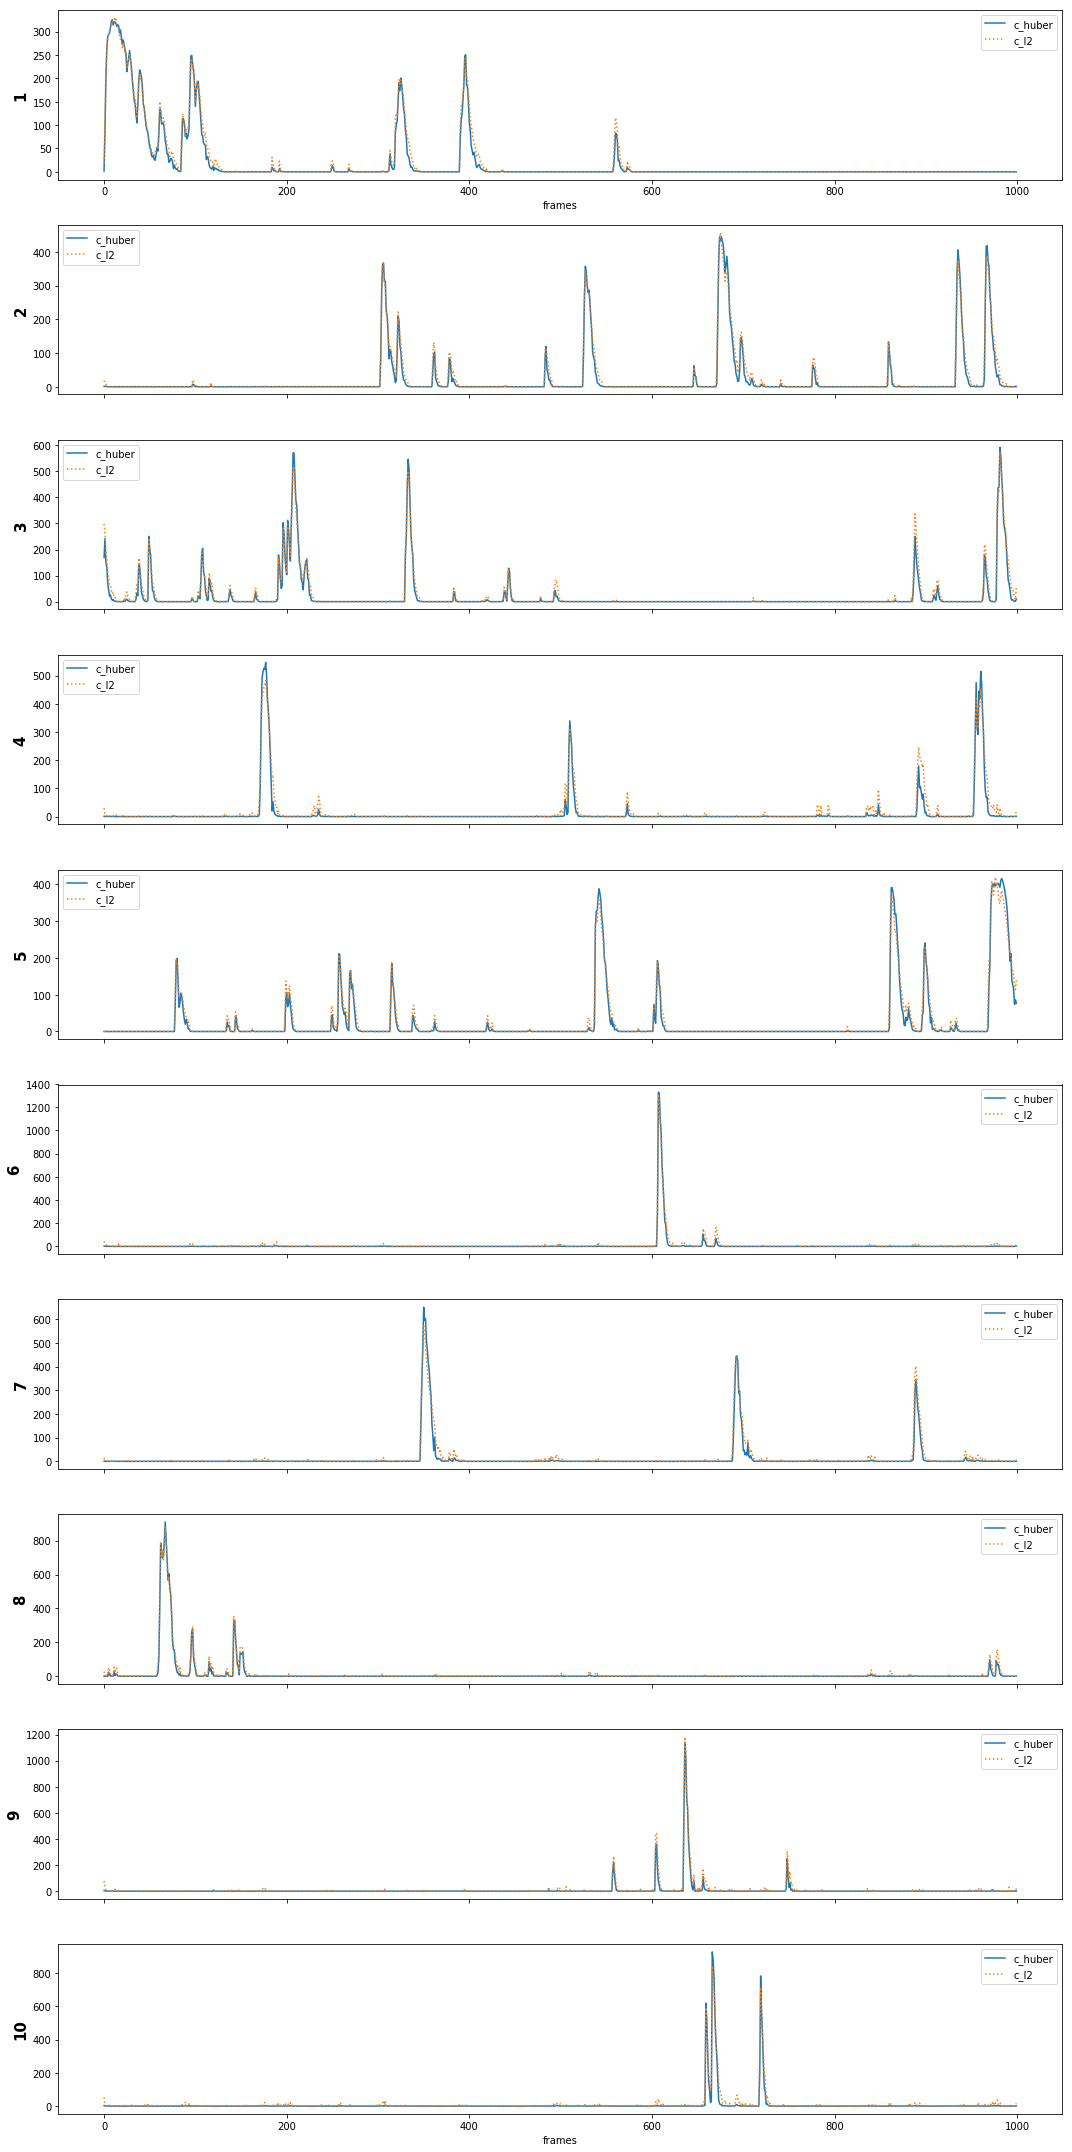

In [116]:
num=10;#len(pure_pix);
fig = plt.figure(figsize=(15,3*num));
for ii in range(num):
    plt.subplot(num,1,ii+1);
    plt.plot(c3[:,ii],label="c_huber");
    plt.plot(c[:,ii],label="c_l2",linestyle=":");
    plt.legend()
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout();
fig.savefig(out_dir + "temporal_huber_constriant_subset.pdf")

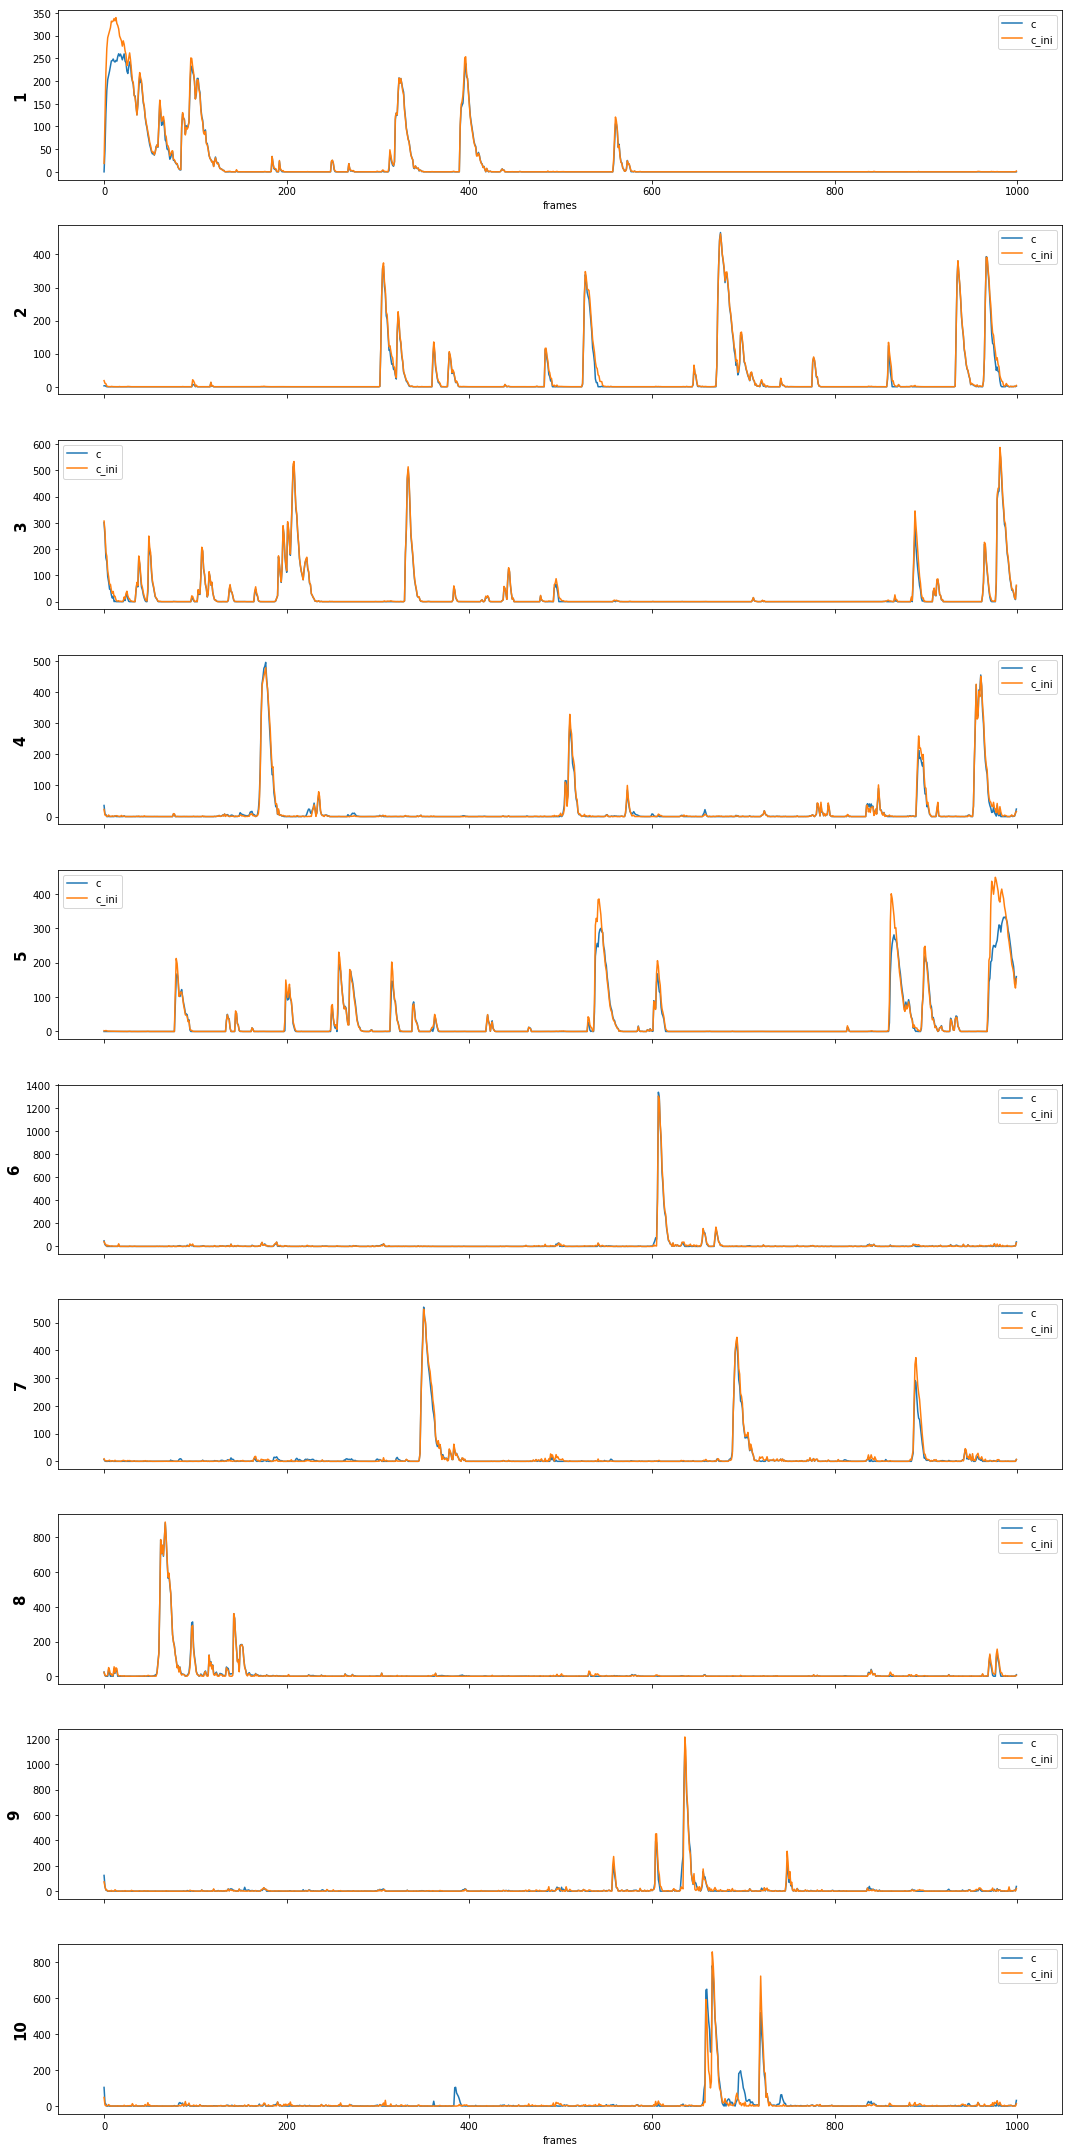

In [117]:
num=10;#len(pure_pix);
fig = plt.figure(figsize=(15,3*num));
for ii in range(num):
    plt.subplot(num,1,ii+1);
    plt.plot(H1[ii,:],label="c");
    plt.plot(c_ini[:,ii],label="c_ini");
    plt.legend()
    plt.ylabel(f"{ii+1}",fontweight="bold",fontsize=15)
    if (ii > 0 and ii < num-1):
        plt.tick_params(axis='x',which='both',labelbottom='off')
    else:
        plt.xlabel("frames");
fig.tight_layout();
fig.savefig(out_dir + "temp_nmf_subset.pdf")